In [57]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)


def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None # tells SQLite to autocommit 
        #any changes
        conn.execute(c)

#return a list of all tables and views in our databases
def show_tables():
    q = '''select
                 name,
                 type
            from sqlite_master
            where type IN ("table","view");'''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Finding out which genres sell the most tracks in the USA

In [58]:
q = '''
WITH tracks_sold_in_USA AS
 (
   SELECT il.* FROM invoice_line il
   INNER JOIN invoice iv ON il.invoice_id = iv.invoice_id
   INNER JOIN customer c ON iv.customer_id = c.customer_id
   WHERE c.country = "USA"
   )
SELECT
       g.name Genre,
       count(tracks_usa.invoice_line_id) tracks_sold,
       cast(count(tracks_usa.invoice_line_id) as float)/
       (select count(*) from tracks_sold_in_USA) Percentage
FROM tracks_sold_in_USA tracks_usa
INNER JOIN track t ON tracks_usa.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 3 DESC
   '''
run_query(q)

,Genre,tracks_sold,Percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


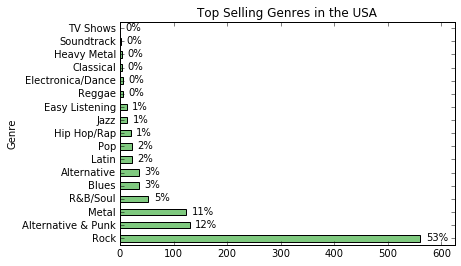

In [59]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index("Genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "Percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

根据结果显示，美国Rock, Alternative & Punk, Metal三种流派的音乐销量最高。

## Analyzing Employee Sales Performance

In [60]:
q2 = '''
SELECT e.first_name || " " || e.last_name employee_name,
       SUM(iv.total) total
FROM employee e 
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice iv ON c.customer_id = iv.customer_id
GROUP BY e.employee_id'''

run_query(q2)

,employee_name,total
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


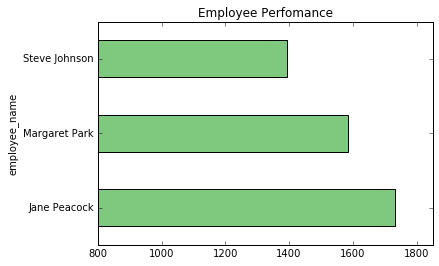

In [61]:
employee_sales = run_query(q2)
employee_sales.set_index("employee_name",inplace=True, drop=True)

employee_sales["total"].plot.barh(
    title="Employee Perfomance",
    xlim=(800, 1850),
    colormap=plt.cm.Accent)

Jane Peacock的销量是最多的。

## Analyzing Sales by Country

In [62]:
q3 = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(q3)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

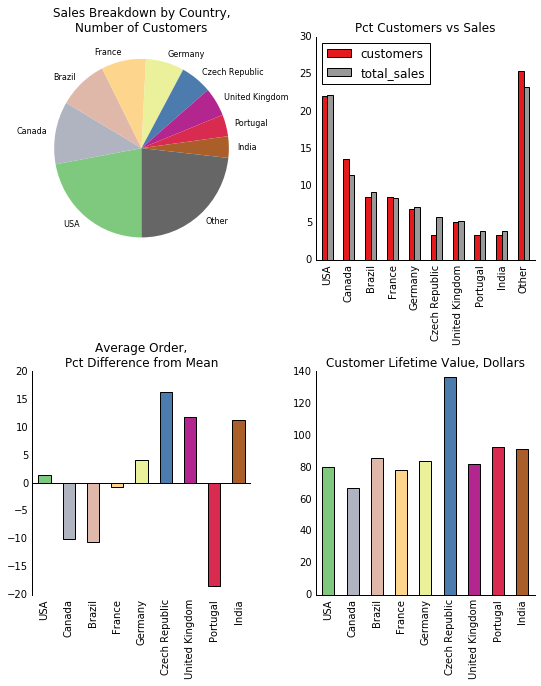

In [63]:
country_metrics = run_query(q3)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

从中，我们可以知道比较有发展前景的市场是：
* Czech Republic
* United Kingdom
* India

## Albums vs Individual Tracks

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
* Number of invoices
* Percentage of invoices

In [64]:
q4 = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(q4)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
